# XAI techniques

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import shap

In [34]:
df = pd.read_csv("data/raw/UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


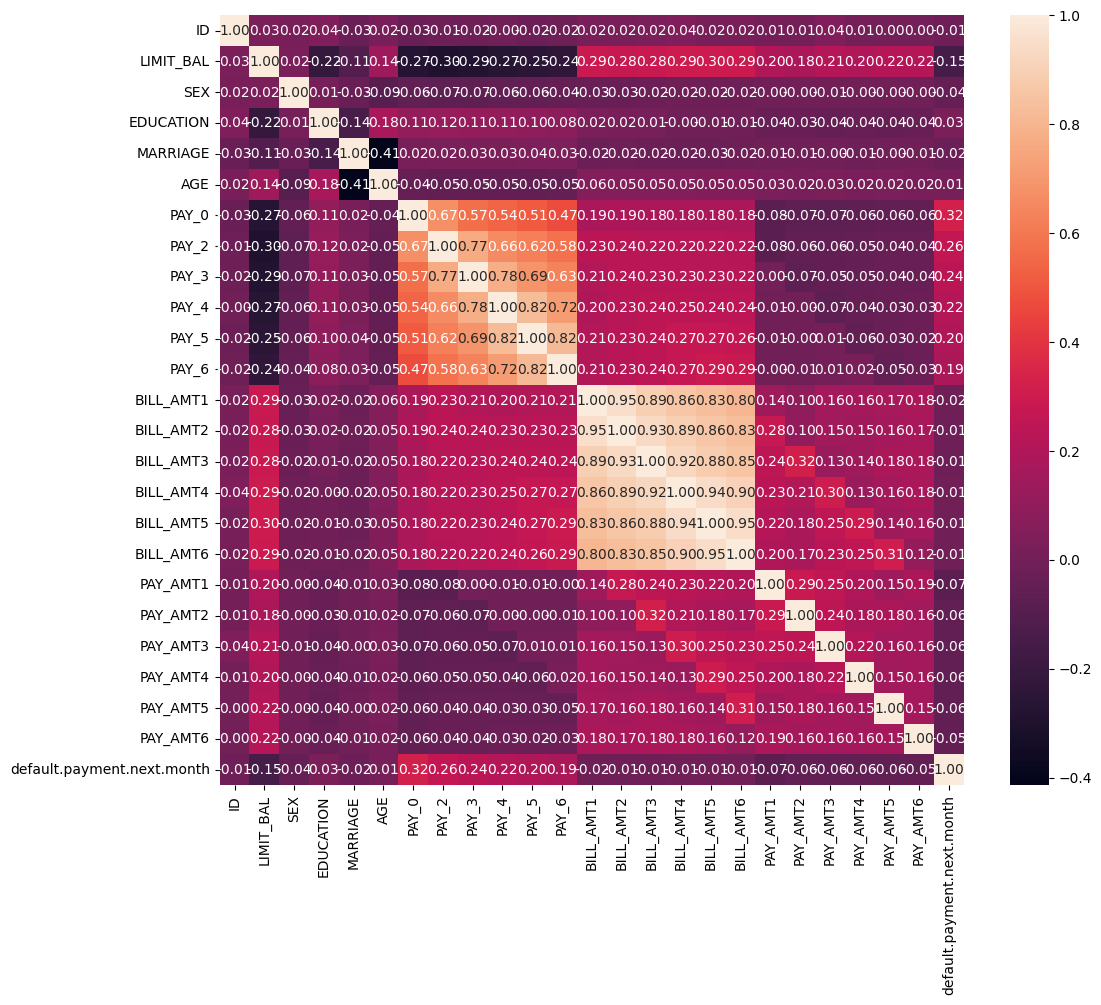

In [35]:
# Check correlation between features
corr_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

C:\Users\javir\AppData\Local\Temp\ipykernel_6868\1005498118.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


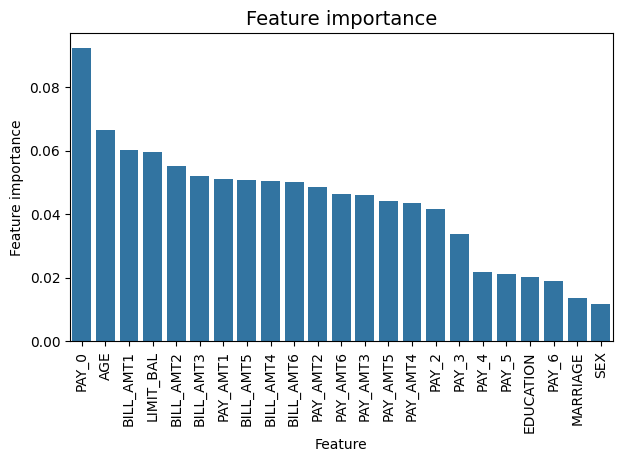

In [36]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

train_df, val_df = train_test_split(df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

clf.fit(train_df[predictors], train_df[target].values)

preds = clf.predict(val_df[predictors])

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

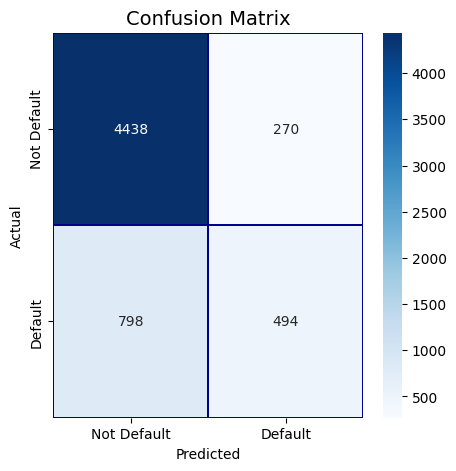

Accuracy 0.822
ROC AUC Score 0.6625018741566295


In [37]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,fmt="d",ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()
print("Accuracy", accuracy_score(val_df[target].values, preds))
print("ROC AUC Score", roc_auc_score(val_df[target].values, preds))

# XAI methods

# Global methods

Baseline ROC-AUC: 0.7619290069468738


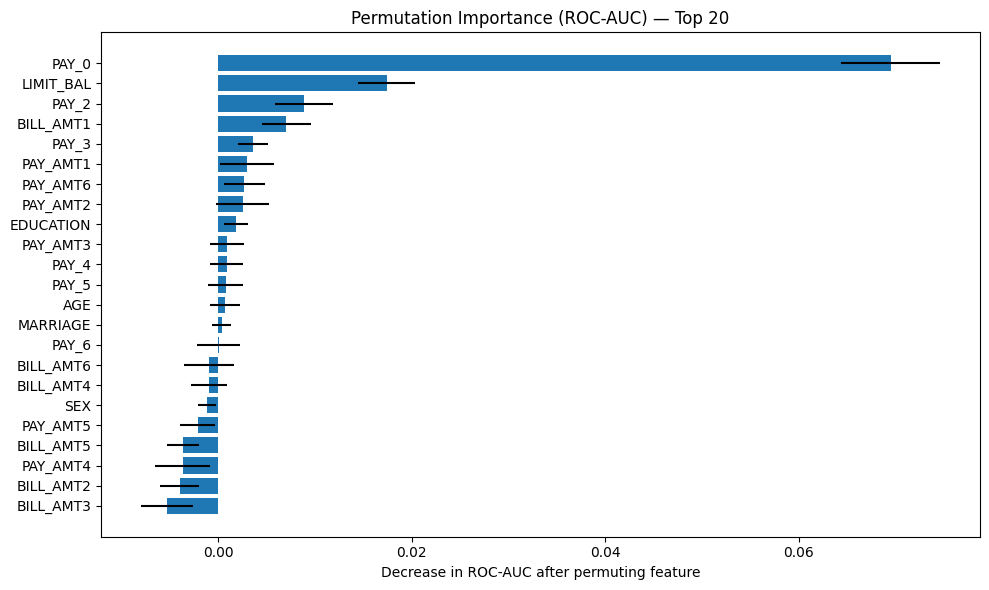

In [38]:
# Validation data
X_val = val_df_bkp[predictors]
y_val = val_df_bkp[target].values

# Use probabilities for ROC-AUC
y_val_proba = clf.predict_proba(X_val)[:, 1]
print("Baseline ROC-AUC:", roc_auc_score(y_val, y_val_proba))

# Permutation importance w.r.t. ROC-AUC
perm = permutation_importance(
    clf, X_val, y_val,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": X_val.columns,
    "importance_mean": perm.importances_mean, # type:ignore
    "importance_std": perm.importances_std # type:ignore
}).sort_values("importance_mean", ascending=False)


# Plot Top-20
plt.figure(figsize=(10, 6))
top = perm_df[::-1]
plt.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"])
plt.xlabel("Decrease in ROC-AUC after permuting feature")
plt.title("Permutation Importance (ROC-AUC) — Top 20")
plt.tight_layout()
plt.show()

## Small sanity check, see if the negative importance variables, when removed, improve the model

In [39]:
# Remove the features with negative importance
neg_imp_features = perm_df[perm_df["importance_mean"] < 0]["feature"].tolist()
print("Features with negative importance:", neg_imp_features)
new_predictors = [f for f in predictors if f not in neg_imp_features]
print("Remaining features:", new_predictors)


newclf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

# Retrain model with new predictors
newclf.fit(train_df[new_predictors], train_df[target].values)
new_preds = newclf.predict_proba(val_df[new_predictors])[:,1]
print("ROC AUC Score after removing negative importance features:", roc_auc_score(val_df[target].values, new_preds))

Features with negative importance: ['BILL_AMT6', 'BILL_AMT4', 'SEX', 'PAY_AMT5', 'BILL_AMT5', 'PAY_AMT4', 'BILL_AMT2', 'BILL_AMT3']
Remaining features: ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT6']
ROC AUC Score after removing negative importance features: 0.7649684286807779


Logically, the ROC AUC Score improves, ever so sligthly after removing the negative importance features

100%|===================| 5992/6000 [07:13<00:00]        

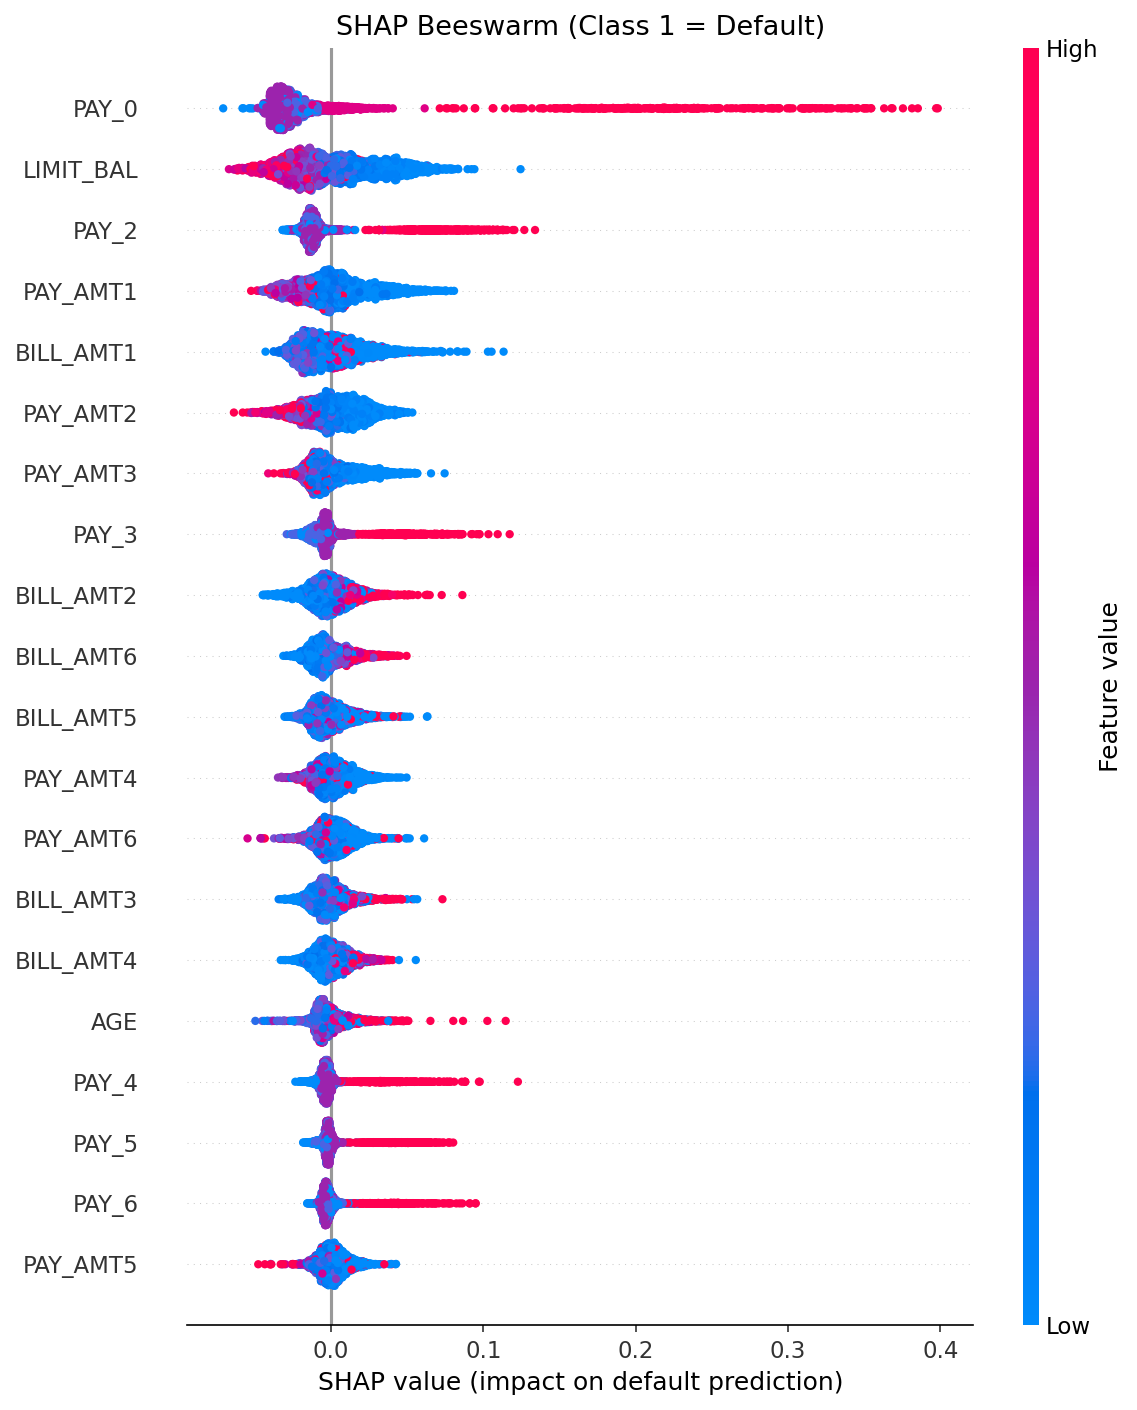

In [18]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 1) Data (use your existing val/train + predictors)
# -----------------------------
X_train = train_df_bkp[predictors]
X_val   = val_df_bkp[predictors]

# Optional: subsample for speed (keeps plot stable + readable)
bg = X_train.sample(n=min(2000, len(X_train)), random_state=42)
X_plot = X_val.sample(n=min(3000, len(X_val)), random_state=42)

# -----------------------------
# 2) SHAP values (RandomForest)
# -----------------------------
explainer = shap.TreeExplainer(clf, data=bg, feature_perturbation="interventional")
sv = explainer.shap_values(X_plot)

# Pick class 1 (default=1) if SHAP returns a list (older API)
if isinstance(sv, list):
    shap_values = sv[1]
else:
    shap_values = sv
    # If it still has a class dimension at the end, select class 1
    if shap_values.ndim == 3:
        shap_values = shap_values[:, :, 1]

# -----------------------------
# 3) Beeswarm (readable axes)
# -----------------------------
plt.figure(figsize=(11, 7), dpi=150)
shap.summary_plot(
    shap_values,
    X_plot,
    plot_type="dot",      # beeswarm
    max_display=20,       # top features shown
    show=False
)

ax = plt.gca()
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)
ax.set_xlabel("SHAP value (impact on default prediction)", fontsize=12)
plt.title("SHAP Beeswarm (Class 1 = Default)", fontsize=13)
plt.tight_layout()
plt.show()


# Local Explanations

## Shap

Confusion matrix:
 [[4438  270]
 [ 798  494]]
Selected index: 2187 | Case: FN | true=1 pred=0 proba(default=1)=0.360
Top SHAP feature: PAY_3 | contribution: +0.0825


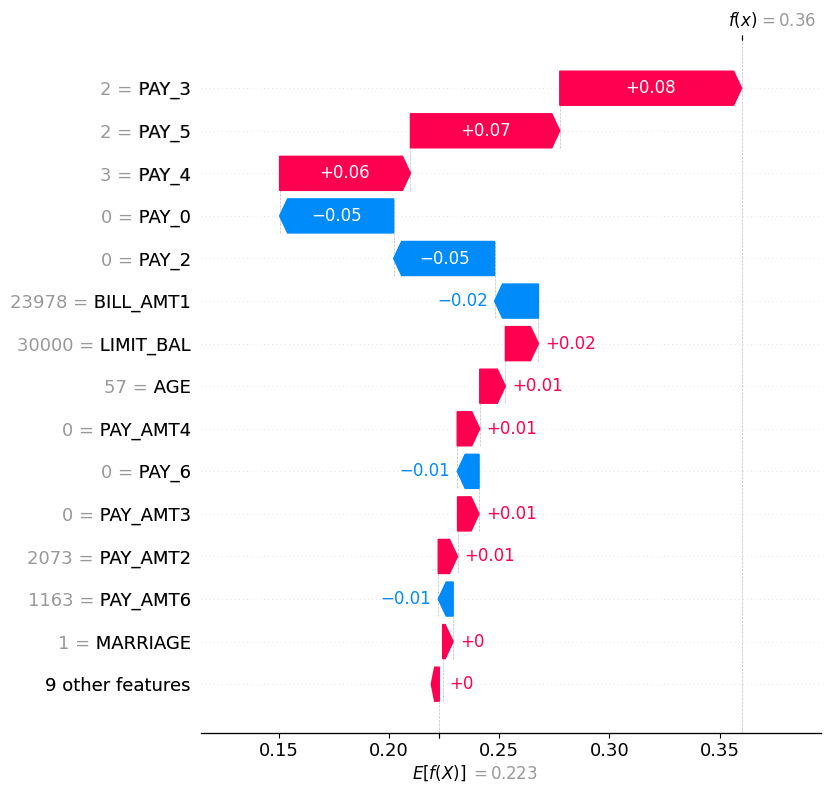

In [40]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# -----------------------------
# Helper: pick an instance by outcome type (TP/TN/FP/FN) or correct/incorrect
# -----------------------------
def pick_instance_for_explanation(
    clf,
    X_df: pd.DataFrame,
    y_true: np.ndarray,
    want: str = "incorrect",          # "correct" | "incorrect" | "TP" | "TN" | "FP" | "FN"
    random_state: int = 42
):
    rng = np.random.default_rng(random_state)
    y_pred = clf.predict(X_df)
    y_proba = clf.predict_proba(X_df)[:, 1]

    idx = X_df.index

    tp = idx[(y_true == 1) & (y_pred == 1)]
    tn = idx[(y_true == 0) & (y_pred == 0)]
    fp = idx[(y_true == 0) & (y_pred == 1)]
    fn = idx[(y_true == 1) & (y_pred == 0)]

    if want.lower() == "tp":
        pool, label = tp, "TP"
    elif want.lower() == "tn":
        pool, label = tn, "TN"
    elif want.lower() == "fp":
        pool, label = fp, "FP"
    elif want.lower() == "fn":
        pool, label = fn, "FN"
    elif want.lower() == "correct":
        pool = tp.append(tn) if hasattr(tp, "append") else tp.union(tn)  # pandas compat
        label = "Correct (TP/TN)"
    elif want.lower() == "incorrect":
        pool = fp.append(fn) if hasattr(fp, "append") else fp.union(fn)
        label = "Incorrect (FP/FN)"
    else:
        raise ValueError("want must be one of: correct, incorrect, TP, TN, FP, FN")

    if len(pool) == 0:
        raise ValueError(f"No instances found for selection: {want}")

    chosen = rng.choice(pool.to_numpy())
    # Determine exact type for chosen
    if chosen in tp: case = "TP"
    elif chosen in tn: case = "TN"
    elif chosen in fp: case = "FP"
    else: case = "FN"

    x0 = X_df.loc[[chosen]]
    return {
        "index": chosen,
        "case": case,
        "y_true": int(y_true[list(idx).index(chosen)]),
        "y_pred": int(y_pred[list(idx).index(chosen)]),
        "proba_1": float(y_proba[list(idx).index(chosen)]),
        "x0": x0
    }

# -----------------------------
# 1) Prepare your validation data
# -----------------------------
X_val = val_df_bkp[predictors]
y_val = val_df_bkp[target].values

# (optional) quick confusion matrix print
y_pred = clf.predict(X_val)
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))

# -----------------------------
# 2) Choose what you want to explain
#    want = "TP"|"TN"|"FP"|"FN" or "correct"/"incorrect"
# -----------------------------
sel = pick_instance_for_explanation(
    clf=clf,
    X_df=X_val,
    y_true=y_val,
    want="FN",        # <-- change here: "TP", "TN", "FP", "FN", "correct", "incorrect"
    random_state=7
)

print(
    f"Selected index: {sel['index']} | Case: {sel['case']} | "
    f"true={sel['y_true']} pred={sel['y_pred']} proba(default=1)={sel['proba_1']:.3f}"
)

x0 = sel["x0"]  # 1-row DataFrame

# =====================================================================
# SHAP Local Explanation (waterfall + top feature)
# =====================================================================
explainer_shap = shap.TreeExplainer(clf)

sv = explainer_shap.shap_values(x0)

# class-1 handling across SHAP versions
if isinstance(sv, list):
    sv1 = sv[1]                      # (1, n_features)
else:
    sv1 = np.array(sv)
    if sv1.ndim == 3:
        sv1 = sv1[:, :, 1]           # (1, n_features)

values_1d = np.array(sv1)[0]         # (n_features,)

ev = explainer_shap.expected_value
base_value = ev[1] if isinstance(ev, (list, np.ndarray)) else ev

exp = shap.Explanation(
    values=values_1d,
    base_values=base_value,
    data=x0.iloc[0].values,
    feature_names=x0.columns
)

# Top influencing feature (absolute SHAP)
messi_shap = pd.Series(values_1d, index=x0.columns)
top_feature = messi_shap.abs().idxmax()
top_contribution = float(messi_shap[top_feature])
print(f"Top SHAP feature: {top_feature} | contribution: {top_contribution:+.4f}")

# Waterfall plot
shap.plots.waterfall(exp, max_display=15)

## Lime

FP count: 270 | FN count: 798
Selected index: 20920 | Type: Borderline FP/FN (conflicting signals) | proba(default=1): 0.5
Selected index: 20920 | Type: Borderline FP/FN (conflicting signals) | proba(default=1): 0.5
Selected index: 20920 | Type: Borderline FP/FN (conflicting signals) | proba(default=1): 0.5


C:\Users\javir\AppData\Local\Temp\ipykernel_6868\3390894366.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Selected index:", i, "| Type:", case_type, "| proba(default=1):", float(clf.predict_proba(x0)[:,1]))


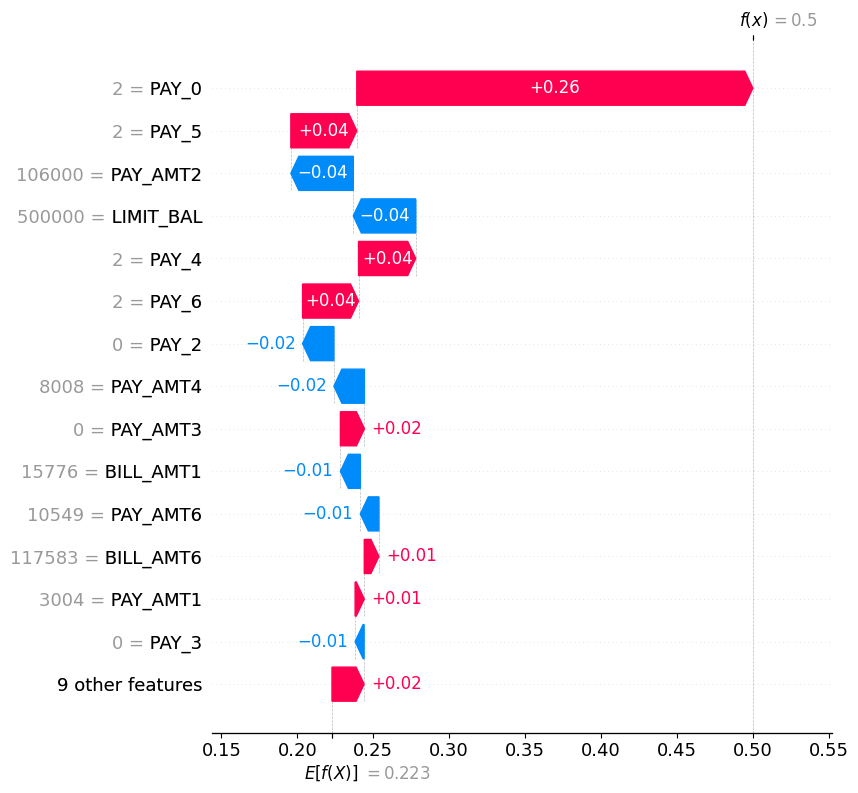

In [47]:
from sklearn.metrics import confusion_matrix

X_val = val_df[predictors]
y_val = val_df[target].values
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

# Indices for FP / FN
fp_idx = val_df.index[(y_val == 0) & (y_pred == 1)]
fn_idx = val_df.index[(y_val == 1) & (y_pred == 0)]

print("FP count:", len(fp_idx), "| FN count:", len(fn_idx))

# Choose one case to explain (highest-confidence FP or FN)
if len(fp_idx) > 0:
    # highest predicted prob among FPs
    i = fp_idx[np.argmax(y_proba[val_df.index.get_indexer(fp_idx)])]
    case_type = "False Positive (pred=1, true=0)"
elif len(fn_idx) > 0:
    # lowest predicted prob among FNs
    i = fn_idx[np.argmin(y_proba[val_df.index.get_indexer(fn_idx)])]
    case_type = "False Negative (pred=0, true=1)"
else:
    # fallback: most confident prediction
    i = val_df.index[np.argmax(np.abs(y_proba - 0.5))]
    case_type = "Most confident case (fallback)"

# ------------------- OR
# Borderline false positives / false negatives
fp = fp_idx
fn = fn_idx

candidates = np.concatenate([fp, fn])
candidate_positions = val_df.index.get_indexer(candidates)

# Distances to boundary
dist = np.abs(y_proba[candidate_positions] - 0.5)

i = candidates[np.argmin(dist)]
case_type = "Borderline FP/FN (conflicting signals)"

x0 = val_df.loc[[i], predictors]
proba0 = clf.predict_proba(x0)[:, 1].item()

print(
    "Selected index:", i,
    "| Type:", case_type,
    "| proba(default=1):", round(proba0, 3)
)


x0 = val_df.loc[[i], predictors]
print("Selected index:", i, "| Type:", case_type, "| proba(default=1):", float(clf.predict_proba(x0)[:,1]))

x0 = val_df.loc[[i], predictors]

proba0 = clf.predict_proba(x0)[:, 1].item()   # <- evita DeprecationWarning
print("Selected index:", i, "| Type:", case_type, "| proba(default=1):", proba0)

explainer = shap.TreeExplainer(clf)

# SHAP values (compatibilidad entre versiones)
sv = explainer.shap_values(x0)

# Elegimos la clase 1 (default=1) si viene como lista
if isinstance(sv, list):
    sv1 = sv[1]              # shape (1, n_features)
else:
    sv1 = sv                 # puede ser (1, n_features) o (1, n_features, 2)

sv1 = np.array(sv1)

# Si aún hay dimensión de clases al final, selecciona clase 1
if sv1.ndim == 3:
    sv1 = sv1[:, :, 1]       # -> (1, n_features)

values_1d = sv1[0]           # -> (n_features,)

# expected value para clase 1
ev = explainer.expected_value
base_value = ev[1] if isinstance(ev, (list, np.ndarray)) else ev

exp = shap.Explanation(
    values=values_1d,
    base_values=base_value,
    data=x0.iloc[0].values,
    feature_names=x0.columns
)

shap.plots.waterfall(exp, max_display=15)

## Lime

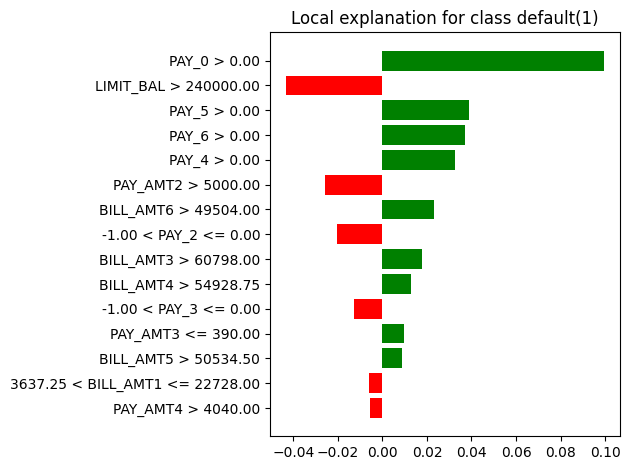

In [48]:

import lime
import lime.lime_tabular
# =====================================================================
# LIME Local Explanation (classification mode)
# =====================================================================
# Build explainer on training data (recommended)
X_train = train_df_bkp[predictors]

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(),
    feature_names=X_train.columns.tolist(),
    class_names=["no_default(0)", "default(1)"],
    mode="classification",
    discretize_continuous=True
)

lime_exp = lime_explainer.explain_instance(
    data_row=x0.iloc[0].to_numpy(),
    predict_fn=lambda a: clf.predict_proba(pd.DataFrame(a, columns=X_train.columns)),
    num_features=15
)
fig = lime_exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

## Sanity check

In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.base import clone

# =========================
# BASELINE AUC
# =========================
X_val = val_df[predictors]
y_val = val_df[target].values

y_val_proba = clf.predict_proba(X_val)[:, 1]
auc_base = roc_auc_score(y_val, y_val_proba)

print(f"Baseline ROC-AUC: {auc_base:.3f}")


# =========================
# DROP-COLUMN: remove PAY_0
# =========================
predictors_drop = [p for p in predictors if p != "PAY_0"]

clf_drop = RandomForestClassifier(
    n_jobs=NO_JOBS,
    random_state=RANDOM_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)

clf_drop.fit(train_df[predictors_drop], train_df[target].values)

y_val_proba_drop = clf_drop.predict_proba(val_df[predictors_drop])[:, 1]
auc_drop = roc_auc_score(y_val, y_val_proba_drop)

print(f"ROC-AUC without PAY_0: {auc_drop:.3f}")
print(f"AUC drop: {auc_base - auc_drop:.3f}")   


Baseline ROC-AUC: 0.762
ROC-AUC without PAY_0: 0.731
AUC drop: 0.031


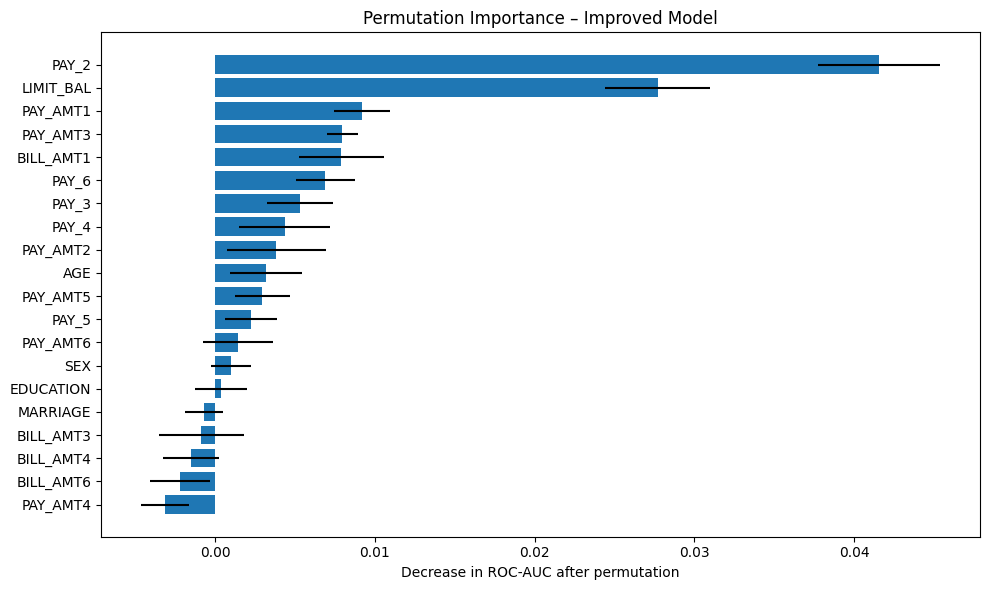

In [61]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

# =========================
# PERMUTATION IMPORTANCE
# =========================
X_val_new = val_df[predictors_drop]
y_val = val_df[target].values

result = permutation_importance(
    clf_drop,
    X_val_new,
    y_val,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc",
    n_jobs=NO_JOBS
)

perm_df = pd.DataFrame({
    "feature": X_val_new.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)


# Plot
plt.figure(figsize=(10, 6))
top = perm_df.head(20)[::-1]
plt.barh(
    top["feature"],
    top["importance_mean"],
    xerr=top["importance_std"]
)
plt.xlabel("Decrease in ROC-AUC after permutation")
plt.title("Permutation Importance – Improved Model")
plt.tight_layout()
plt.show()


In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.base import clone

# =========================
# BASELINE AUC
# =========================
X_val = val_df[predictors]
y_val = val_df[target].values

y_val_proba = clf.predict_proba(X_val)[:, 1]
auc_base = roc_auc_score(y_val, y_val_proba)

print(f"Baseline ROC-AUC: {auc_base:.3f}")


# =========================
# DROP-COLUMN: remove PAY_0
# =========================
predictors_drop = [p for p in predictors if p != "PAY_0"]

clf_drop = RandomForestClassifier(
    n_jobs=NO_JOBS,
    random_state=RANDOM_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)

clf_drop.fit(train_df[predictors_drop], train_df[target].values)

y_val_proba_drop = clf_drop.predict_proba(val_df[predictors_drop])[:, 1]
auc_drop = roc_auc_score(y_val, y_val_proba_drop)

print(f"ROC-AUC without PAY_0: {auc_drop:.3f}")
print(f"AUC drop: {auc_base - auc_drop:.3f}") 


# =========================
# DROP-COLUMN: remove PAY_0 and PAY_2
# =========================
predictors_drop = [p for p in predictors if p != "PAY_0" and p != "PAY_2"]

clf_drop = RandomForestClassifier(
    n_jobs=NO_JOBS,
    random_state=RANDOM_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)

clf_drop.fit(train_df[predictors_drop], train_df[target].values)

y_val_proba_drop = clf_drop.predict_proba(val_df[predictors_drop])[:, 1]
auc_drop_2 = roc_auc_score(y_val, y_val_proba_drop)

print(f"ROC-AUC without PAY_0 and PAY_2: {auc_drop_2:.3f}")
print(f"AUC drop: {auc_drop - auc_drop_2:.3f}") 

Baseline ROC-AUC: 0.762
ROC-AUC without PAY_0: 0.731
AUC drop: 0.031
ROC-AUC without PAY_0 and PAY_2: 0.723
AUC drop: 0.008


# Possible improvement given the XAI results

In [ ]:
# =========================
# PAY feature engineering
# =========================
pay_cols = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

df_fe = df.copy()

# Average repayment delay (overall behavior)
df_fe["PAY_mean"] = df_fe[pay_cols].mean(axis=1)

# Worst repayment delay (extreme risk)
df_fe["PAY_max"] = df_fe[pay_cols].max(axis=1)

# Trend: recent vs past behavior
df_fe["PAY_trend"] = df_fe["PAY_0"] - df_fe[["PAY_3", "PAY_4", "PAY_5", "PAY_6"]].mean(axis=1)

# Define weights (recent months weighted more)
weights = [0.30, 0.25, 0.2, 0.13, 0.10, 0.10]

# Safety check: normalize weights in case they don't sum to 1
weights = np.array(weights)
weights = weights / weights.sum()

df_fe["PAY_wma"] = df_fe[pay_cols].values @ weights

# =========================
# Define predictors (IMPROVED)
# =========================
pay_cols = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

predictors_improved = [
    p for p in predictors if p not in pay_cols
] + ["PAY_mean", "PAY_max", "PAY_trend", "PAY_wma"]

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_fe,
    test_size=VALID_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True
)

train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()


from sklearn.ensemble import RandomForestClassifier

clf_improved = RandomForestClassifier(
    n_jobs=NO_JOBS,
    random_state=RANDOM_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)

clf_improved.fit(
    train_df[predictors_improved],
    train_df[target].values
)

from sklearn.metrics import roc_auc_score, accuracy_score

X_val = val_df[predictors_improved]
y_val = val_df[target].values

y_val_proba = clf_improved.predict_proba(X_val)[:, 1]
y_val_pred  = clf_improved.predict(X_val)

print("Improved model ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("Improved model Accuracy:", accuracy_score(y_val, y_val_pred))

Improved model ROC-AUC: 0.7634401690291999
Improved model Accuracy: 0.8225


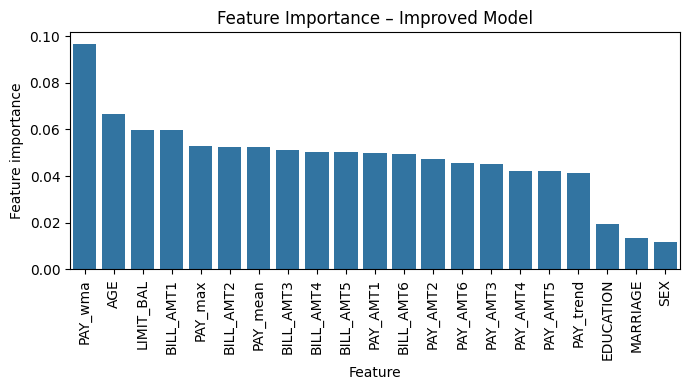

In [ ]:
tmp = pd.DataFrame({
    "Feature": predictors_improved,
    "Feature importance": clf_improved.feature_importances_
}).sort_values(by="Feature importance", ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x="Feature", y="Feature importance", data=tmp)
plt.xticks(rotation=90)
plt.title("Feature Importance – Improved Model")
plt.tight_layout()
plt.show()

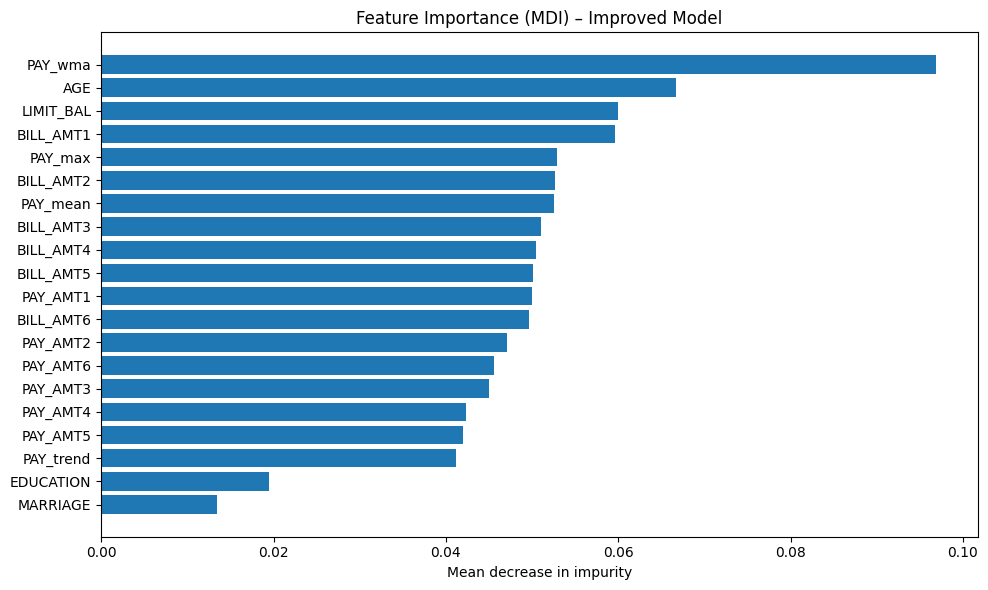

In [96]:
# =========================
# FEATURE IMPORTANCE (MDI)
# =========================
imp_df = pd.DataFrame({
    "feature": predictors_improved,
    "importance_mean": clf_improved.feature_importances_
}).sort_values("importance_mean", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
top = imp_df.head(20)[::-1]
plt.barh(
    top["feature"],
    top["importance_mean"]
)
plt.xlabel("Mean decrease in impurity")
plt.title("Feature Importance (MDI) – Improved Model")
plt.tight_layout()
plt.show()


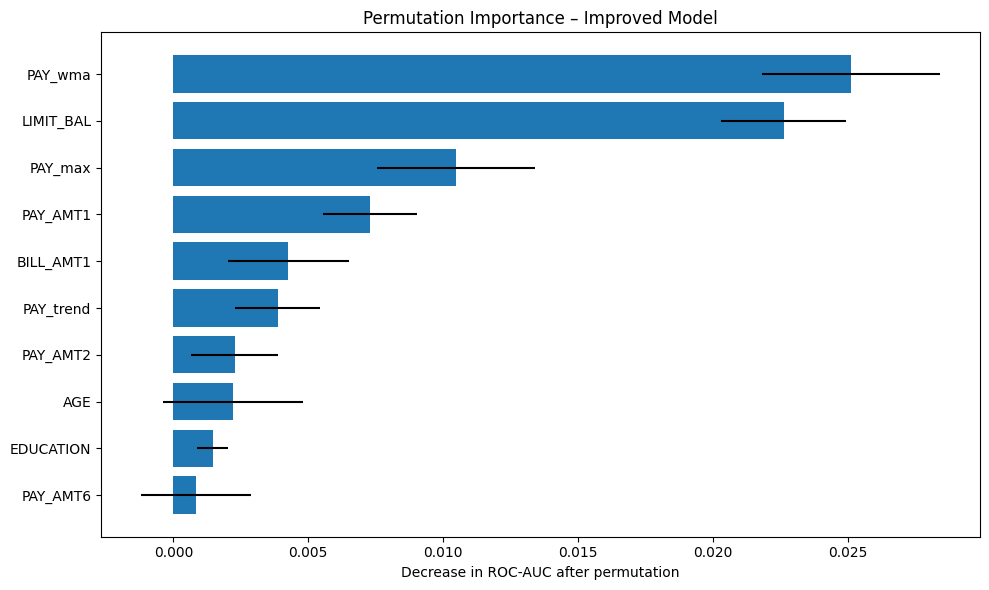

In [97]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# PERMUTATION IMPORTANCE – NEW MODEL
# =========================
X_val_new = val_df[predictors_improved]
y_val = val_df[target].values

result = permutation_importance(
    clf_improved,                 # <- modelo nuevo
    X_val_new,
    y_val,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc",
    n_jobs=NO_JOBS
)

perm_df = pd.DataFrame({
    "feature": X_val_new.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

# Plot (mismo estilo)
plt.figure(figsize=(10, 6))
top = perm_df.head(10)[::-1]
plt.barh(
    top["feature"],
    top["importance_mean"],
    xerr=top["importance_std"]
)
plt.xlabel("Decrease in ROC-AUC after permutation")
plt.title("Permutation Importance – Improved Model")
plt.tight_layout()
plt.show()
